In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTETomek
from scipy.stats import randint, uniform

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder as LE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import learning_curve

warnings.filterwarnings("ignore")

print("All libraries loaded")

All libraries loaded


In [18]:
try:
    data = pd.read_csv('informacion_completa_imagenes_V2.csv')
    print("Datos cargados exitosamente.")
except Exception as e:
    print(f"Error al cargar los datos: {e}")
    
print(data.info())

print(data.columns)


Datos cargados exitosamente.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nombre de la imagen               226 non-null    object 
 1   Ángulo entre manecillas           226 non-null    float64
 2   Ángulo manecillas 2pm             226 non-null    float64
 3   Ángulo manecillas 11am            226 non-null    float64
 4   Lowest point                      226 non-null    object 
 5   longitud_manecilla_2pm            226 non-null    float64
 6   longitud_manecilla_11am           226 non-null    float64
 7   Números detectados correctamente  226 non-null    int64  
 8   Números con error espacial        226 non-null    int64  
 9   Números algo detectado            226 non-null    int64  
 10  Total numeros detectados          226 non-null    int64  
 11  Puntuacion contorno               226 non-

In [19]:
data = data.astype({col: 'float64' for col in data.select_dtypes(include='bool').columns})
data[['lowest_point_x', 'lowest_point_y']] = data['Lowest point'].str.strip('()').str.split(',', expand=True).astype(float)
data['longitud_relativa_2pm'] = data['longitud_manecilla_2pm' ] / data['Area Circulo']
data['longitud_relativa_11pm'] = data['longitud_manecilla_11am' ] / data['Area Circulo']

data.drop(columns=['nombre de la imagen','longitud_manecilla_2pm','longitud_manecilla_11am','Lowest point','Diagnostico '],inplace=True)


data = data[data['Tipo'] != 'PR']
data.dropna(subset=['Tipo'], inplace=True)

data['Tipo'] = data['Tipo'].map({'PD': 0, 'HC': 1})
data['Tipo'].fillna(0, inplace=True)

data = data.dropna()

conteo_clases = data['Tipo'].value_counts()

print(conteo_clases)
print(data.info())

Tipo
0    151
1     45
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 225
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           196 non-null    float64
 1   Ángulo manecillas 2pm             196 non-null    float64
 2   Ángulo manecillas 11am            196 non-null    float64
 3   Números detectados correctamente  196 non-null    int64  
 4   Números con error espacial        196 non-null    int64  
 5   Números algo detectado            196 non-null    int64  
 6   Total numeros detectados          196 non-null    int64  
 7   Puntuacion contorno               196 non-null    int64  
 8   Puntuacion manecillas             196 non-null    int64  
 9   Puntuacion numeros                196 non-null    int64  
 10  puntuacion final                  196 non-null    int64  
 11  Area Circulo               

In [20]:
from sklearn.preprocessing import OneHotEncoder

X = data.drop(columns=['Tipo'])
y = data['Tipo']

X = X.dropna()
y = y[X.index]

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

print(X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 225
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           196 non-null    float64
 1   Ángulo manecillas 2pm             196 non-null    float64
 2   Ángulo manecillas 11am            196 non-null    float64
 3   Números detectados correctamente  196 non-null    int64  
 4   Números con error espacial        196 non-null    int64  
 5   Números algo detectado            196 non-null    int64  
 6   Total numeros detectados          196 non-null    int64  
 7   Puntuacion contorno               196 non-null    int64  
 8   Puntuacion manecillas             196 non-null    int64  
 9   Puntuacion numeros                196 non-null    int64  
 10  puntuacion final                  196 non-null    int64  
 11  Area Circulo                      196 non-null    float64
 12  Circularidad 

Datos de entrenamiento: (147, 21), Datos de validación: (63, 21), Datos de prueba ciega: (40, 21)


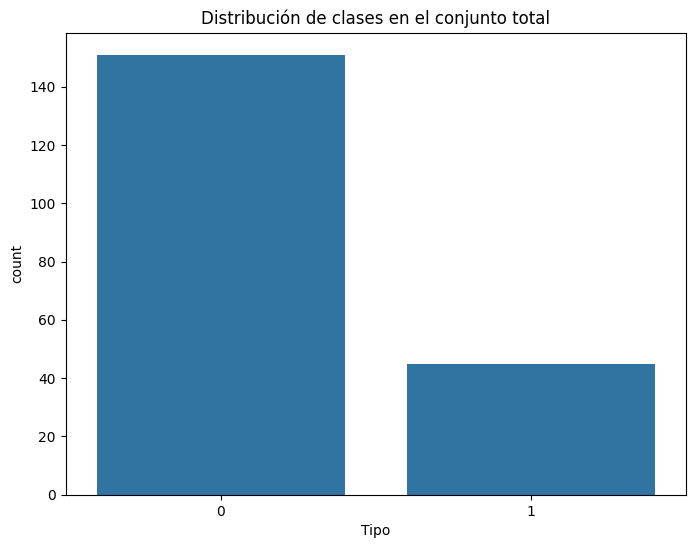

Tipo
0    151
1     45
Name: count, dtype: int64


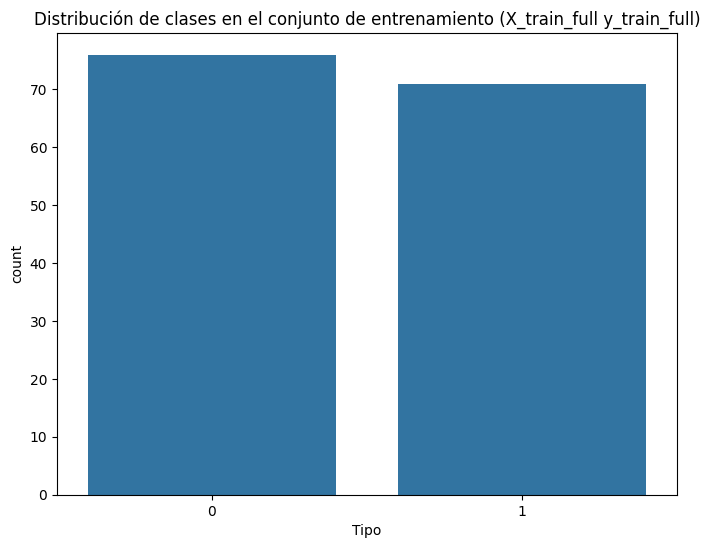

Tipo
0    76
1    71
Name: count, dtype: int64


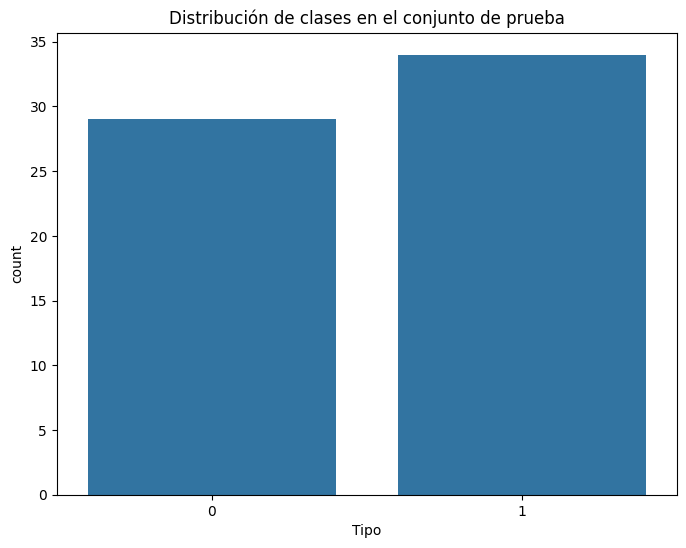

Tipo
1    34
0    29
Name: count, dtype: int64


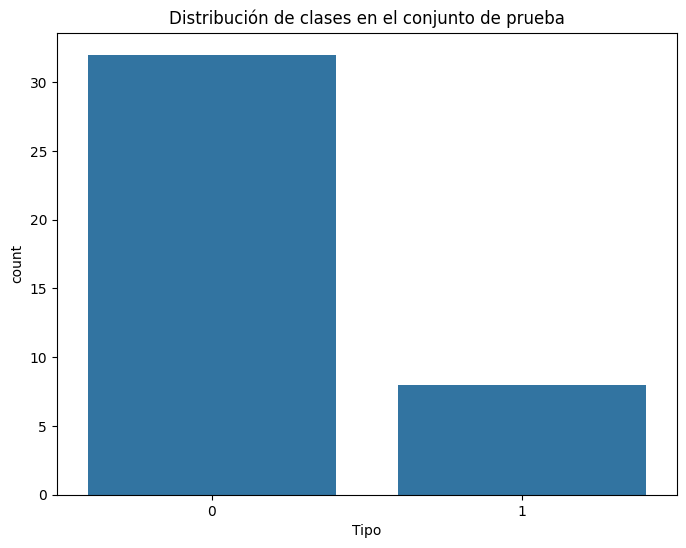

Tipo
0    32
1     8
Name: count, dtype: int64


In [22]:
X_train, X_test_blind, y_train, y_test_blind = train_test_split(X, y, test_size=0.2, random_state=42)  

smote = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


print(f"Datos de entrenamiento: {X_train_full.shape}, Datos de validación: {X_test_full.shape}, Datos de prueba ciega: {X_test_blind.shape}")

plt.figure(figsize=(8,6))
sns.countplot(x=y)
plt.title('Distribución de clases en el conjunto total')
plt.show()
print(y.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_train_full)
plt.title('Distribución de clases en el conjunto de entrenamiento (X_train_full y_train_full)')
plt.show()
print(y_train_full.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_test_full)
plt.title('Distribución de clases en el conjunto de prueba')
plt.show()
print(y_test_full.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_test_blind)
plt.title('Distribución de clases en el conjunto de prueba')
plt.show()
print(y_test_blind.value_counts())

In [23]:
param_grid = {
    'estimator__max_depth': [3, 5, 7, None],
    'estimator__min_samples_split': [2, 5, 10],  
    'estimator__min_samples_leaf': [1, 2, 4],  
    'estimator__max_features': ['auto', 'sqrt', 'log2'], 
    'n_estimators': [10, 50, 100, 200],
    'max_samples': [0.5, 0.75, 1.0], 
    'bootstrap': [True, False],  
    'bootstrap_features': [True, False], 
    'oob_score': [True, False],  
    'warm_start': [True, False]  
}
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)

In [24]:
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator = bagging, 
    param_distributions=param_grid, 
    n_iter=50, 
    cv=cv_strategy, 
    random_state=42, 
    n_jobs=-1,
    scoring='f1',
    verbose=2
)


In [25]:
random_search.fit(X_train_full, y_train_full)
print("Mejores hiperparámetros encontrados:", random_search.best_params_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Mejores hiperparámetros encontrados: {'warm_start': True, 'oob_score': False, 'n_estimators': 10, 'max_samples': 0.75, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 1, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 7, 'bootstrap_features': False, 'bootstrap': True}


In [26]:
y_val_pred = random_search.predict(X_test_full)

print("Evaluación en el conjunto de validación:")
print(f"Accuracy: {accuracy_score(y_test_full, y_val_pred):.4f}")
print(f"Precision: {precision_score(y_test_full, y_val_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_full, y_val_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_full, y_val_pred, average='weighted'):.4f}")
print("\nReporte de clasificación:\n" + classification_report(y_test_full, y_val_pred))


Evaluación en el conjunto de validación:
Accuracy: 0.8730
Precision: 0.8780
Recall: 0.8730
F1 Score: 0.8718

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        29
           1       0.84      0.94      0.89        34

    accuracy                           0.87        63
   macro avg       0.88      0.87      0.87        63
weighted avg       0.88      0.87      0.87        63



In [27]:
y_test_blind_pred = random_search.best_estimator_.predict(X_test_blind)
print("Evaluación en conjunto de prueba ciega:")
print(f"Accuracy: {accuracy_score(y_test_blind, y_test_blind_pred):.4f}")
print(f"Precision: {precision_score(y_test_blind, y_test_blind_pred):.4f}")
print(f"Recall: {recall_score(y_test_blind, y_test_blind_pred):.4f}")
print(f"F1 Score: {f1_score(y_test_blind, y_test_blind_pred):.4f}")


Evaluación en conjunto de prueba ciega:
Accuracy: 0.8000
Precision: 0.5000
Recall: 0.6250
F1 Score: 0.5556


In [28]:
y_test_pred = random_search.best_estimator_.predict(X_train)
print("Evaluación en conjunto train original:")
print(f"Accuracy: {accuracy_score(y_train, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_test_pred):.4f}")
print(f"F1 Score: {f1_score(y_train, y_test_pred):.4f}")


Evaluación en conjunto train original:
Accuracy: 0.8782
Precision: 0.6957
Recall: 0.8649
F1 Score: 0.7711


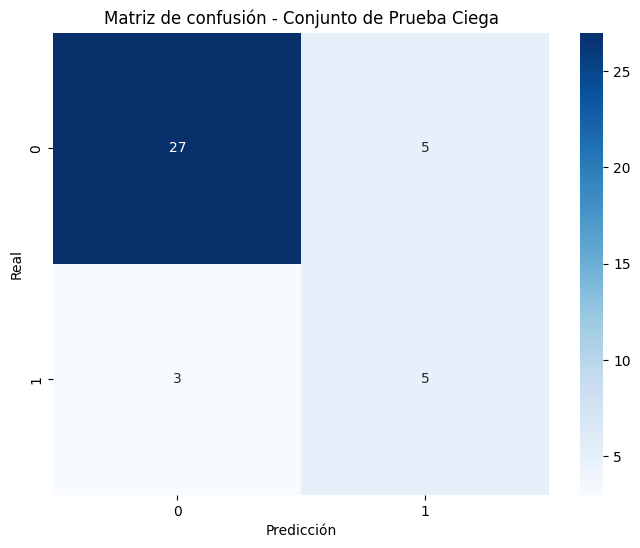

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_blind, y_test_blind_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Prueba Ciega')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


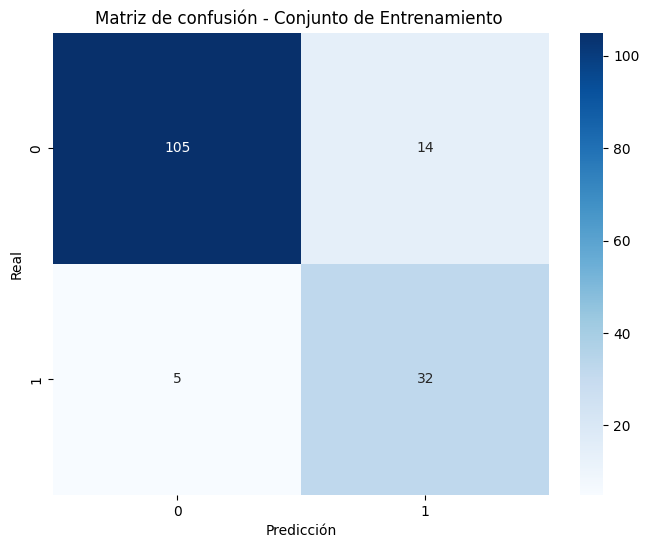

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_train, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Entrenamiento ')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


Características más importantes en BaggingClassifier:
Manecilla 11 correcta               0.191259
Ángulo manecillas 2pm               0.146563
lowest_point_x                      0.092383
Ángulo entre manecillas             0.068987
longitud_relativa_11pm              0.067322
lowest_point_y                      0.055003
Circularidad                        0.052544
Ángulo manecillas 11am              0.039855
Números detectados correctamente    0.036883
Números con error espacial          0.036184
dtype: float64


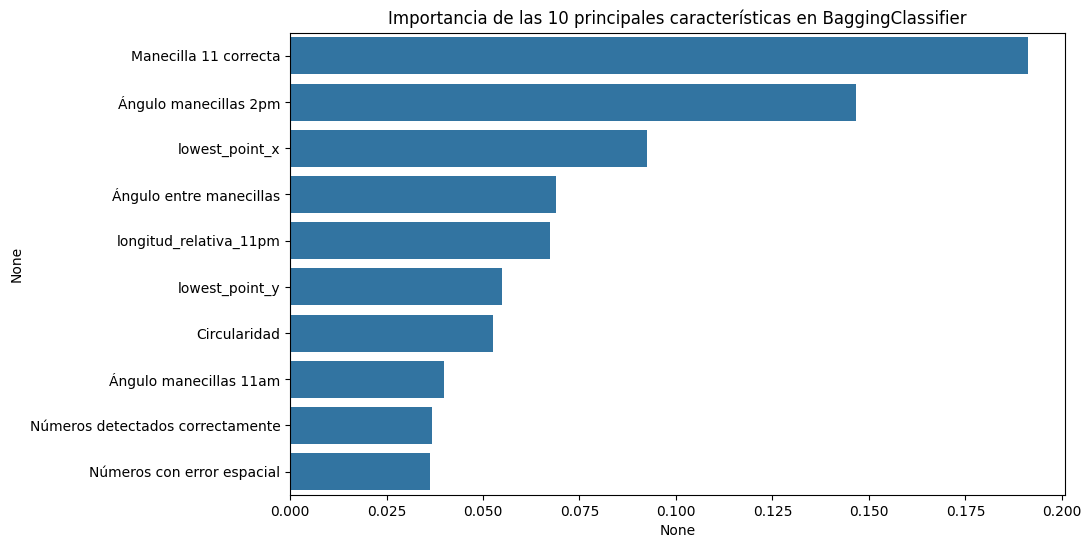

In [31]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in random_search.best_estimator_.estimators_
], axis=0)

importancias_bagging = pd.Series(feature_importances, index=X_train_full.columns).sort_values(ascending=False)

print("Características más importantes en BaggingClassifier:")
print(importancias_bagging.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=importancias_bagging.head(10), y=importancias_bagging.index[:10])
plt.title("Importancia de las 10 principales características en BaggingClassifier")
plt.show()


In [32]:
from joblib import dump, load
dump(random_search, 'bagging_model.joblib')

['bagging_model.joblib']